[![Dataflowr](https://raw.githubusercontent.com/dataflowr/website/master/_assets/dataflowr_logo.png)](https://dataflowr.github.io/website/)

# [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239) for MNIST
(J. Ho, A. Jain, P. Abbeel 2020)

![](https://raw.githubusercontent.com/dataflowr/website/master/modules/extras/diffusions/ddpm.png)


Given a schedule $\beta_1<\beta_2<\dots <\beta_T$, the **forward diffusion process** is defined by:
$q(x_t|x_{t-1}) = \mathcal{N}(x_t; \sqrt{1-\beta_t}x_{t-1},\beta_t I)$ and $q(x_{1:T}|x_0) = \prod_{t=1}^T q(x_t|x_{t-1})$.

With $\alpha_t = 1-\beta_t$ and $\overline{\alpha_t} = \prod_{i=1}^t\alpha_i$, we see that, with $\epsilon\sim\mathcal{N}(0,I)$:
\begin{align*}
x_t = \sqrt{\overline{\alpha}_t}x_0 + \sqrt{1-\overline{\alpha}_t}\epsilon.
\end{align*}
The law $q(x_{t-1}|x_t,\epsilon)$ is explicit: $q(x_{t-1}|x_t,\epsilon) = \mathcal{N}(x_{t-1};\mu(x_t,\epsilon,t), \gamma_t I)$ with,
\begin{align*}
\mu(x_t,\epsilon, t) = \frac{1}{\sqrt{\alpha_t}}\left( x_t-\frac{1-\alpha_t}{\sqrt{1-\overline{\alpha}_t}}\epsilon\right)\text{ and, }
\gamma_t = \frac{1-\overline{\alpha}_{t-1}}{1-\overline{\alpha}_{t}}\beta_t
\end{align*}


**Training**: to approximate **the reversed diffusion** $q(x_{t-1}|x_t)$ by a neural network given by $p_{\theta}(x_{t-1}|x_t) = \mathcal{N}(x_{t-1}; \mu_{\theta}(x_t,t), \beta_t I)$ and $p(x_T) \sim \mathcal{N}(0,I)$, we maximize the usual Variational bound:
\begin{align*}
\mathbb{E}_{q(x_0)} \ln p_{\theta}(x_0) &\geq L_T +\sum_{t=2}^T L_{t-1}+L_0 \text{ with, }L_{t-1} = \mathbb{E}_q\left[ \frac{1}{2\sigma_t^2}\|\mu_\theta(x_t,t) -\mu(x_t,\epsilon,t)\|^2\right].
\end{align*}
With the change of variable:
\begin{align*}
\mu_\theta(x_t,t) = \frac{1}{\sqrt{\alpha_t}}\left( x_t-\frac{1-\alpha_t}{\sqrt{1-\overline{\alpha}_t}}\epsilon_\theta(x_t,t)\right),
\end{align*}
ignoring the prefactor and sampling $\tau$ instead of summing over all $t$, the loss is finally:
\begin{align*}
\ell(\theta) = \mathbb{E}_\tau\mathbb{E}_\epsilon \left[ \|\epsilon - \epsilon_\theta(\sqrt{\overline{\alpha}_\tau}x_0 + \sqrt{1-\overline{\alpha}_\tau}\epsilon, \tau)\|^2\right]
\end{align*}



**Sampling**: to simulate the reversed diffusion with the learned $\epsilon_\theta(x_t,t)$ starting from $x_T\sim \mathcal{N}(0,I)$, iterate for $t=T,\dots, 1$:
\begin{align*}
x_{t-1} = \frac{1}{\sqrt{\alpha_t}}\left( x_t-\frac{1-\alpha_t}{\sqrt{1-\overline{\alpha}_t}}\epsilon_\theta(x_t,t)\right)+\sqrt{\beta_t}\epsilon,\text{ with } \epsilon\sim\mathcal{N}(0,I).
\end{align*}

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from tqdm.notebook import tqdm

In [2]:
def show_images(images, title=""):
    """Shows the provided images as sub-pictures in a square"""
    images = [im.permute(1,2,0).numpy() for im in images]

    # Defining number of rows and columns
    fig = plt.figure(figsize=(8, 8))
    rows = int(len(images) ** (1 / 2))
    cols = round(len(images) / rows)

    # Populating figure with sub-plots
    idx = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, idx + 1)

            if idx < len(images):
                plt.imshow(images[idx], cmap="gray")
                plt.axis('off')
                idx += 1
    fig.suptitle(title, fontsize=30)
    
    # Showing the figure
    plt.show()

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
def sinusoidal_embedding(n, d):
    # Returns the standard positional embedding
    embedding = torch.tensor([[i / 10_000 ** (2 * j / d) for j in range(d)] for i in range(n)])
    sin_mask = torch.arange(0, n, 2)

    embedding[1 - sin_mask] = torch.cos(embedding[sin_mask])
    embedding[sin_mask] = torch.sin(embedding[sin_mask])

    return embedding

In [5]:
class MyConv(nn.Module):
    def __init__(self, shape, in_c, out_c, kernel_size=3, stride=1, padding=1, activation=None, normalize=True):
        super(MyConv, self).__init__()
        self.ln = nn.LayerNorm(shape)
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size, stride, padding)
        self.activation = nn.SiLU() if activation is None else activation
        self.normalize = normalize

    def forward(self, x):
        out = self.ln(x) if self.normalize else x
        out = self.conv1(out)
        out = self.activation(out)
        return out
    
def MyTinyBlock(size, in_c, out_c):
    return nn.Sequential(MyConv((in_c, size, size), in_c, out_c), 
                         MyConv((out_c, size, size), out_c, out_c), 
                         MyConv((out_c, size, size), out_c, out_c))

def MyTinyUp(size, in_c):
    return nn.Sequential(MyConv((in_c, size, size), in_c, in_c//2), 
                         MyConv((in_c//2, size, size), in_c//2, in_c//4), 
                         MyConv((in_c//4, size, size), in_c//4, in_c//4))

In [6]:
class MyTinyUNet(nn.Module):
  # Here is a network with 3 down and 3 up with the tiny block
    def __init__(self, in_c=1, out_c=1, size=32, n_steps=1000, time_emb_dim=100):
        super(MyTinyUNet, self).__init__()

        # Sinusoidal embedding
        self.time_embed = nn.Embedding(n_steps, time_emb_dim)
        self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_emb_dim)
        self.time_embed.requires_grad_(False)

        # First half
        self.te1 = self._make_te(time_emb_dim, 1)
        self.b1 = MyTinyBlock(size, in_c, 10)
        self.down1 = nn.Conv2d(10, 10, 4, 2, 1)
        self.te2 = self._make_te(time_emb_dim, 10)
        self.b2 = MyTinyBlock(size//2, 10, 20)
        self.down2 = nn.Conv2d(20, 20, 4, 2, 1)
        self.te3 = self._make_te(time_emb_dim, 20)
        self.b3 = MyTinyBlock(size//4, 20, 40)
        self.down3 = nn.Conv2d(40, 40, 4, 2, 1)

        # Bottleneck
        self.te_mid = self._make_te(time_emb_dim, 40)
        self.b_mid = nn.Sequential(
            MyConv((40, size//8, size//8), 40, 20),
            MyConv((20, size//8, size//8), 20, 20),
            MyConv((20, size//8, size//8), 20, 40)
        )

        # Second half
        self.up1 = nn.ConvTranspose2d(40, 40, 4, 2, 1)
        self.te4 = self._make_te(time_emb_dim, 80)
        self.b4 = MyTinyUp(size//4, 80)
        self.up2 = nn.ConvTranspose2d(20, 20, 4, 2, 1)
        self.te5 = self._make_te(time_emb_dim, 40)
        self.b5 = MyTinyUp(size//2, 40)
        self.up3 = nn.ConvTranspose2d(10, 10, 4, 2, 1)
        self.te_out = self._make_te(time_emb_dim, 20)
        self.b_out = MyTinyBlock(size, 20, 10)
        self.conv_out = nn.Conv2d(10, out_c, 3, 1, 1)

    def forward(self, x, t): # x is (bs, in_c, size, size) t is (bs)
        t = self.time_embed(t)
        n = len(x)
        out1 = self.b1(x + self.te1(t).reshape(n, -1, 1, 1))  # out1.shape = (bs, 10, size, size)
        out2 = self.b2(self.down1(out1) + self.te2(t).reshape(n, -1, 1, 1))  # out2.shape = (bs, 20, size/2, size/2)
        out3 = self.b3(self.down2(out2) + self.te3(t).reshape(n, -1, 1, 1))  # out3.shape = (bs, 40, size/4, size/4)
        # down3.shape = (bs, 40, size/8, size/8)
        out_mid = self.b_mid(self.down3(out3) + self.te_mid(t).reshape(n, -1, 1, 1))  # outmid.shape=(bs, 40, size/8, size/8)
        # up1.shape = (bs, 40, size/4, size/4)
        out4 = torch.cat((out3, self.up1(out_mid)), dim=1)  # out4.shape=(bs, 80, size/4, size/4)
        out4 = self.b4(out4 + self.te4(t).reshape(n, -1, 1, 1))  # out4.shape=(bs, 20, size/4, size/4)
        out5 = torch.cat((out2, self.up2(out4)), dim=1)  # out5.shape=(bs, 40, size/2, size/2)
        out5 = self.b5(out5 + self.te5(t).reshape(n, -1, 1, 1))  # out5.shape=(bs, 10, size/2, size/2)
        out = torch.cat((out1, self.up3(out5)), dim=1)  # out.shape=(bs, 20, size, size)
        out = self.b_out(out + self.te_out(t).reshape(n, -1, 1, 1))  # out.shape=(bs, 10, size, size)
        out = self.conv_out(out) # (bs, out_c, size, size)
        return out

    def _make_te(self, dim_in, dim_out):
        return nn.Sequential(nn.Linear(dim_in, dim_out), nn.SiLU(), nn.Linear(dim_out, dim_out))

The `MyTinyUNet` is a versy small implementation of a convolutional UNet where a time embedding has been added at each step. To make things simple, we need to have an image of size $s\times s$ with $s$ divisible by 8 (this is why we will increase the size of the MNIST dataset from $28\times 28$ to $32 \times 32$).

In [7]:
bs = 3
x = torch.randn(bs,1,32,32)
n_steps=1000
timesteps = torch.randint(0, n_steps, (bs,)).long()
unet = MyTinyUNet(in_c =1, out_c =1, size=32)

In [8]:
y = unet(x,timesteps)
y.shape

torch.Size([3, 1, 32, 32])

In [50]:
class DDPM(nn.Module):
    def __init__(self, network, num_timesteps, beta_start=0.0001, beta_end=0.02, device=device) -> None:
        super(DDPM, self).__init__()
        self.num_timesteps = num_timesteps
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps, dtype=torch.float32).to(device).reshape(-1,1,1,1)
        self.sqrt_betas = self.betas ** 0.5
        self.alphas = 1.0 - self.betas
        self.sqrt_alphas = self.alphas ** 0.5
        self.reciprocal_sqrt_alphas = 1 / self.sqrt_alphas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.network = network
        self.device = device
        self.sqrt_alphas_cumprod = self.alphas_cumprod ** 0.5 # used in add_noise
        self.sqrt_one_minus_alphas_cumprod = (1 - self.alphas_cumprod) ** 0.5 # used in add_noise and step
        self.one_a_div_sqrt_one_ac = (1-self.alphas)/self.sqrt_one_minus_alphas_cumprod
        self.sampler = torch.distributions.Normal(torch.tensor(0.0), torch.tensor(1.0))

    def add_noise(self, x_start, x_noise, timesteps):
        # The forward process
        # x_start and x_noise (bs, n_c, w, d)
        # timesteps (bs)
        #
        # your code here
        # .reshape(-1,1,1,1) to make broadcast available
        return self.sqrt_alphas_cumprod[timesteps]*x_start + self.sqrt_one_minus_alphas_cumprod[timesteps]*x_noise
        # pass

    def reverse(self, x, t):
        # The network return the estimation of the noise we added
        return self.network(x, t)
    
    def step(self, model_output, timestep, sample):
        # one step of sampling
        # timestep (1)
        #
        # your code here
        if timestep > 0:
            eps = self.sampler.sample(sample.shape).to(device)
        else:
            eps = 0
        # xt_eps = sample-(1-self.alphas[timestep])/self.sqrt_one_minus_alphas_cumprod[timestep] * model_output
        return self.reciprocal_sqrt_alphas[timestep] * (sample- self.one_a_div_sqrt_one_ac[timestep]* model_output) + self.sqrt_betas[timestep] * eps
        # return 1/self.sqrt_alphas[timestep]
        # pass

In [10]:
m1 = torch.distributions.Normal(torch.tensor(0.0), torch.tensor(1.0))
m2 = torch.distributions.Normal(torch.zeros(1,32,32, dtype=torch.float32), 
                               torch.ones(1,32,32, dtype=torch.float32))
import time
start = time.time()
for i in range(1000):
    K1 = m1.sample((1,32,32))
end = time.time()
print(f'm1 time = {(end-start): .2f}ms')
start = time.time()
for i in range(1000):
    K2 = m2.sample((1,)).squeeze(0)
end = time.time()
print(f'm2 time = {(end-start): .2f}ms')


m1 time =  0.03ms
m2 time =  0.03ms


In [ ]:
# K1.shape,K1, K2, K2.shape
show_images([K1,K2])

The commands below are here to help you and to test your code.

In [12]:
num_timesteps = 1000
betas = torch.linspace(0.0001, 0.02, num_timesteps, dtype=torch.float32).to(device)

In [13]:
betas[timesteps]

tensor([0.0023, 0.0064, 0.0150], device='cuda:0')

In [14]:
betas[10]

tensor(0.0003, device='cuda:0')

In [15]:
betas[timesteps].reshape(-1,1,1,1).shape

torch.Size([3, 1, 1, 1])

In [51]:
network = MyTinyUNet(in_c =1, out_c =1, size=32)
model = DDPM(network, num_timesteps, beta_start=0.0001, beta_end=0.02, device=device)

In [17]:
bs = 5
x = torch.randn(bs,1,32,32).to(device)
timesteps = 10*torch.ones(bs,).long().long().to(device)

In [18]:
timesteps.shape

torch.Size([5])

In [19]:
y = model.add_noise(x,x,timesteps)
y.shape

torch.Size([5, 1, 32, 32])

In [20]:
y = model.step(x,timesteps[0],x)
y.shape

torch.Size([5, 1, 32, 32])

You can check that all the parameters of the UNet `network` are indeed parameters of the DDPM `model` like this:

In [ ]:
for n, p in model.named_parameters():
    print(n, p.shape)

In [22]:
def training_loop(model, dataloader, optimizer, num_epochs, num_timesteps, device=device):
    """Training loop for DDPM"""

    global_step = 0
    losses = []
    
    for epoch in range(num_epochs):
        model.train()
        progress_bar = tqdm(total=len(dataloader))
        progress_bar.set_description(f"Epoch {epoch}")
        for step, batch in enumerate(dataloader):
            batch = batch[0].to(device)
            #
            # your code here
            #
            bs = batch.shape[0]
            timesteps = torch.randint(0, num_timesteps, (bs,)).long().to(device)
            noise = model.sampler.sample(batch.shape).to(device)
            x_t = model.add_noise(batch, noise, timesteps)
            noise_pred = model.reverse(x_t,timesteps)
            loss = torch.nn.functional.mse_loss(noise_pred, noise)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "step": global_step}
            losses.append(loss.detach().item())
            progress_bar.set_postfix(**logs)
            global_step += 1
        
        progress_bar.close()

In [23]:
root_dir = '/home/ubuntu/data'
transform01 = torchvision.transforms.Compose([
        torchvision.transforms.Resize(32),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5), (0.5))
    ])
dataset = torchvision.datasets.MNIST(root=root_dir, train=True, transform=transform01, download=True)
dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=4096, shuffle=True, num_workers=10)

/usr/local/miniconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/miniconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worke

In [ ]:
for b in dataloader:
    batch = b[0]
    break

bn = [b for b in batch[:100]] 
show_images(bn, "origin")

In [25]:
learning_rate = 1e-3
num_epochs = 50
num_timesteps = 1000
network = MyTinyUNet()
network = network.to(device)
model = DDPM(network, num_timesteps, beta_start=0.0001, beta_end=0.02, device=device)
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

In [ ]:
training_loop(model, dataloader, optimizer, num_epochs, num_timesteps, device=device)        


In [52]:
# torch.save(model.state_dict(), "ddpm.pt")
model.load_state_dict(torch.load("ddpm.pt"))
model = model.to(device)

In [57]:
def generate_image(ddpm, sample_size, channel, size):
    """Generate the image from the Gaussian noise"""

    frames = []
    frames_mid = []
    ddpm.eval()
    with torch.no_grad():
        timesteps = list(range(ddpm.num_timesteps))[::-1]
        # sample = torch.randn(sample_size, channel, size, size).to(device)
        sample = ddpm.sampler.sample((sample_size, channel, size, size)).to(device)
        
        for i, t in enumerate(tqdm(timesteps)):
            #
            # your code here
            #
            tstep = torch.ones(sample_size,1, dtype=torch.int32).to(device) * t
            eps = ddpm.reverse(sample, tstep)
            sample = ddpm.step(eps, t, sample)
            if t==500:
                for i in range(sample_size):
                    frames_mid.append(sample[i].detach().cpu())

        for i in range(sample_size):
            frames.append(sample[i].detach().cpu())
    return frames, frames_mid

In [58]:
generated, generated_mid = generate_image(model, 100, 1, 32)

  0%|          | 0/1000 [00:00<?, ?it/s]

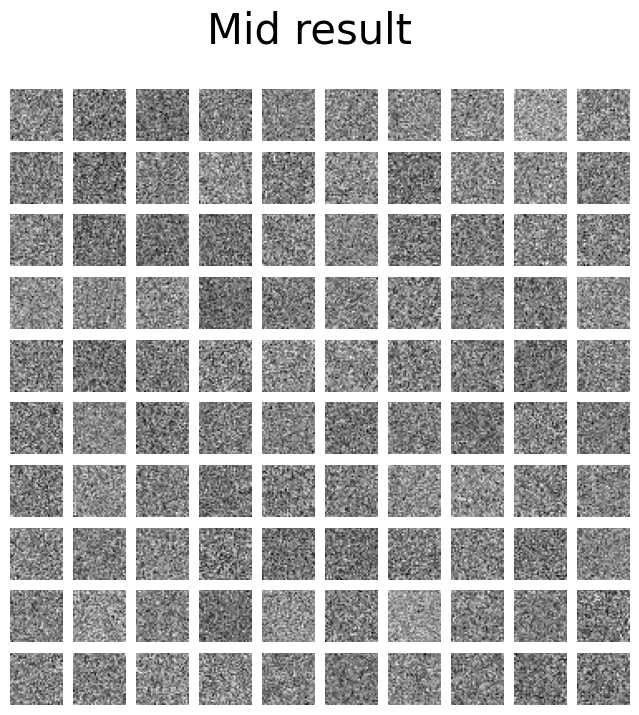

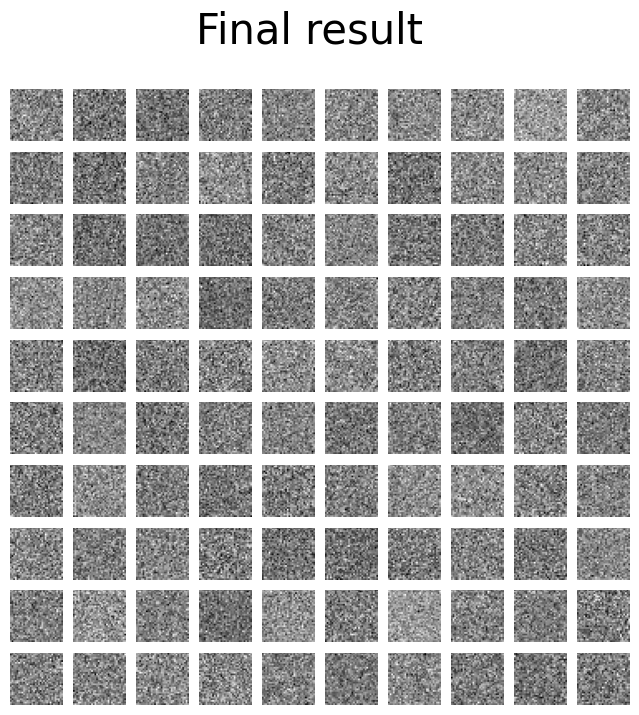

In [59]:
show_images(generated_mid, "Mid result")
show_images(generated, "Final result")